In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc


In [ ]:

df = pd.read_csv("/kaggle/input/smart-manufacturing-iot-cloud-monitoring-dataset/smart_manufacturing_data.csv")
df.head() 

,timestamp,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk,maintenance_required
0,2025-01-01 00:00:00,39,78.61,28.65,79.96,3.73,2.16,1,0,106,Normal,0.0,0
1,2025-01-01 00:01:00,29,68.19,57.28,35.94,3.64,0.69,1,0,320,Normal,0.0,0
2,2025-01-01 00:02:00,15,98.94,50.20,72.06,1.00,2.49,1,1,19,Normal,1.0,1
3,2025-01-01 00:03:00,43,90.91,37.65,30.34,3.15,4.96,1,1,10,Normal,1.0,1
4,2025-01-01 00:04:00,8,72.32,40.69,56.71,2.68,0.63,2,0,65,Vibration Issue,0.0,1


In [ ]:
X_anomaly = df.drop(columns=['timestamp', 'machine_id','anomaly_flag', 'machine_status', 'anomaly_flag', 'predicted_remaining_life' , 'failure_type', 'downtime_risk', 'maintenance_required'])
y_anomaly = df['anomaly_flag'].values.astype(np.float32)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_anomaly).astype(np.float32)
X_scaledDF = pd.DataFrame(X_scaled, columns=X_anomaly.columns)
X_scaledDF.head()


,temperature,vibration,humidity,pressure,energy_consumption
0,0.358297,-1.425542,1.729103,0.633113,-0.452333
1,-0.680397,0.484988,-1.319819,0.555015,-1.584968
2,2.384846,0.012528,1.181932,-1.735870,-0.198068
3,1.584394,-0.824956,-1.707688,0.129813,1.705067
4,-0.268707,-0.622091,0.118757,-0.278034,-1.631198


In [ ]:
# Split train data (85%) dan test data (15%)
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_anomaly, test_size=0.15, random_state=42)

# Split X_temp to train data (70%) and val data (15%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42)  # 0.1765 x 0.85 ≈ 0.15


class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
#Binary Class model For Anomaly Detection

class BinaryClassifierANN(nn.Module):
    def __init__(self, input_dim, hidden_size1, hidden_size2):
        super(BinaryClassifierANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Evaluate and Training Function
input_dim = X_train.shape[1]
train_losses = []
val_losses = []
test_losses = []

train_accuracies = []
val_accuracies = []
test_accuracies = []

def evaluate_model(model, data_loader, loss_fn):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            X_batch, y_batch = batch
            outputs = model(X_batch).squeeze()

            if isinstance(loss_fn, nn.CrossEntropyLoss):
                loss = loss_fn(outputs, y_batch)
                preds = torch.argmax(outputs, dim=1)
            else:
                loss = loss_fn(outputs, y_batch)
                preds = (outputs > 0.5).float()

            total_loss += loss.item()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy



def train_with_eval(model, optimizer, loss_fn, train_loader, val_loader, test_loader, num_epochs):
    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []

    for epoch in range(num_epochs):
        # ===== TRAINING =====
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            X_batch, y_batch = batch 

            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()

            if isinstance(loss_fn, nn.CrossEntropyLoss):
                loss = loss_fn(outputs, y_batch)
                preds = torch.argmax(outputs, dim=1)
            else:
                loss = loss_fn(outputs, y_batch)
                preds = (outputs > 0.5).float()

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total

        # ===== EVALUASI =====
        val_loss, val_accuracy = evaluate_model(model, val_loader, loss_fn)
        test_loss, test_accuracy = evaluate_model(model, test_loader, loss_fn)

        # Simpan semua
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy:.4f} | "
              f"Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f}")

    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies




In [ ]:
#Start Training Model
model_anomaly = BinaryClassifierANN(input_dim, hidden_size1=2, hidden_size2=2)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_anomaly.parameters(), lr=0.001)

train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = train_with_eval(
    model_anomaly, optimizer, loss_fn,
    train_loader, val_loader, test_loader,
    num_epochs=20
)


Epoch 1/20 | Train Loss: 0.3862, Acc: 0.8241 | Val Loss: 0.2116, Acc: 0.9150 | Test Loss: 0.2166, Acc: 0.9116
Epoch 2/20 | Train Loss: 0.1934, Acc: 0.9141 | Val Loss: 0.1503, Acc: 0.9483 | Test Loss: 0.1531, Acc: 0.9461
Epoch 3/20 | Train Loss: 0.1303, Acc: 0.9523 | Val Loss: 0.1036, Acc: 0.9594 | Test Loss: 0.1062, Acc: 0.9560
Epoch 4/20 | Train Loss: 0.0896, Acc: 0.9643 | Val Loss: 0.0699, Acc: 0.9805 | Test Loss: 0.0718, Acc: 0.9804
Epoch 5/20 | Train Loss: 0.0616, Acc: 0.9848 | Val Loss: 0.0492, Acc: 0.9878 | Test Loss: 0.0504, Acc: 0.9883
Epoch 6/20 | Train Loss: 0.0445, Acc: 0.9917 | Val Loss: 0.0364, Acc: 0.9939 | Test Loss: 0.0377, Acc: 0.9936
Epoch 7/20 | Train Loss: 0.0340, Acc: 0.9943 | Val Loss: 0.0287, Acc: 0.9959 | Test Loss: 0.0292, Acc: 0.9961
Epoch 8/20 | Train Loss: 0.0273, Acc: 0.9962 | Val Loss: 0.0238, Acc: 0.9949 | Test Loss: 0.0241, Acc: 0.9955
Epoch 9/20 | Train Loss: 0.0226, Acc: 0.9971 | Val Loss: 0.0198, Acc: 0.9971 | Test Loss: 0.0207, Acc: 0.9964
Epoch 10/2

In [ ]:
#Plot Loss and Scatter Function
def plot_all_curves(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Val Loss', color='orange')
    plt.plot(epochs, test_losses, label='Test Loss', color='green')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Acc', color='blue')
    plt.plot(epochs, val_accuracies, label='Val Acc', color='orange')
    plt.plot(epochs, test_accuracies, label='Test Acc', color='green')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_scatter(ytes, ypred):
    plt.figure(figsize=(10,4))
    plt.scatter(range(len(ytes)),ytes , label='Actual', color='b')
    plt.scatter(range(len(ypred)),ypred, label='Prediction', color='r')
    plt.legend(loc="center right")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Pred vs Actual")
    plt.show()

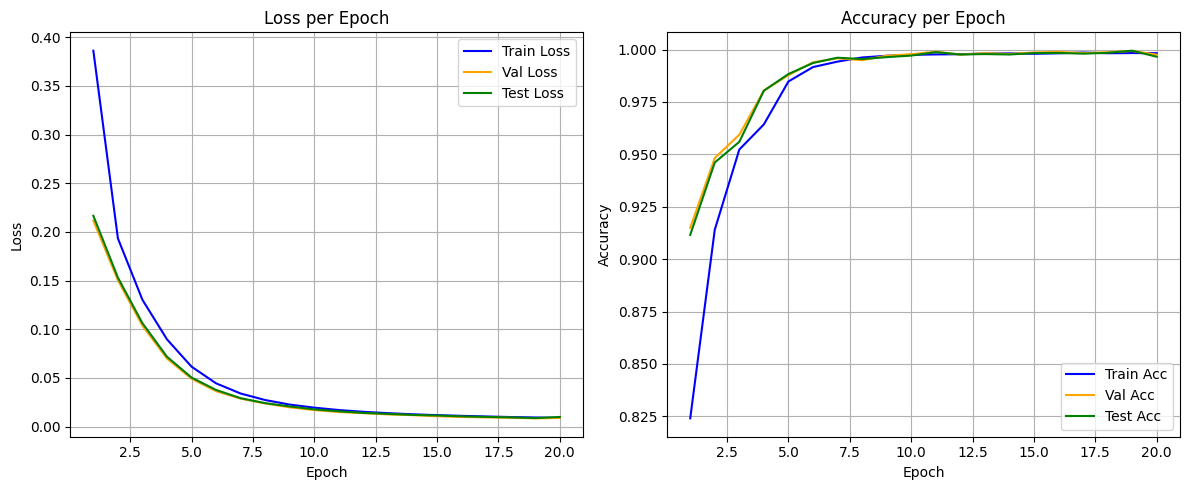

In [ ]:
plot_all_curves(train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies)


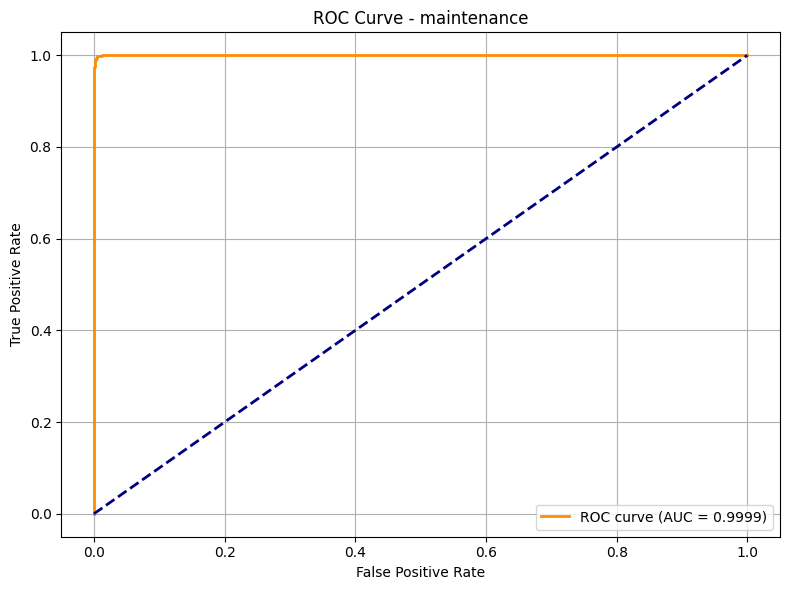

In [ ]:
# Plot ROC CURVE
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
# Probabilitas prediksi (bukan threshold 0.5)
model_anomaly.eval()
with torch.no_grad():
    y_pred = model_anomaly(X_test_tensor).squeeze().numpy()

# ROC Curve dan AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - maintenance')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

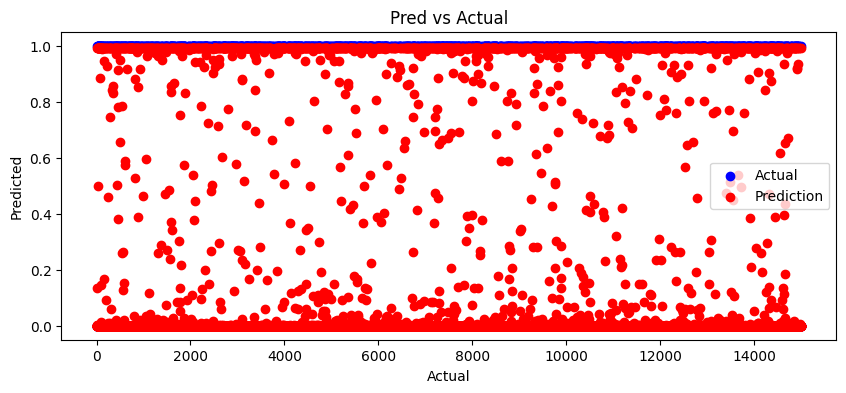

In [ ]:
plot_scatter(y_test, y_pred)

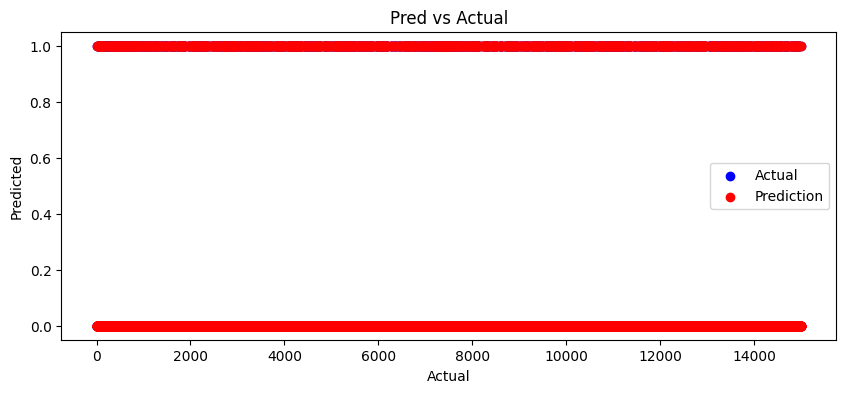

In [ ]:
#Use Threshold 0.5
y_prob = (y_pred >= 0.5).astype(int)
plot_scatter(y_test, y_prob)

In [ ]:
#ACC, F1 Score and Confusion Matrix After using threshold 0.5
acc = accuracy_score(y_test_tensor.numpy(), y_prob)
f1 = f1_score(y_test_tensor.numpy(), y_prob)
cm = confusion_matrix(y_test_tensor.numpy(), y_prob)

print("Anomaly Accuracy:", acc)
print("Anomaly F1 Score:", f1)
print("Confusion Matrix:\n", cm)

Anomaly Accuracy: 0.9966
Anomaly F1 Score: 0.9805269186712485
Confusion Matrix:
 [[13665     9]
 [   42  1284]]


In [ ]:
#Precision, recall, F1 Score for each target data
report = classification_report(y_test, y_prob)
print(report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13674
         1.0       0.99      0.97      0.98      1326

    accuracy                           1.00     15000
   macro avg       0.99      0.98      0.99     15000
weighted avg       1.00      1.00      1.00     15000

